# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("C:/Users/jwhoj/Desktop/clustering/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\jwhoj\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("C:/Users/jwhoj/Desktop/clustering/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# Merge transaction and offer data  w/ customer name, offer_id, and response 
df_merged = df_transactions.merge(df_offers, on='offer_id', how='outer')[['customer_name', 'offer_id', 'n']]

In [5]:
# Remove NaN
matrix = pd.pivot_table(df_merged, index='customer_name', values='n', columns='offer_id').fillna(0)

In [6]:
# Remove NaN
matrix.reset_index(level=0, inplace=True)

In [7]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller values of SS represent better clusters because this means the distance between each data point and its center
is smaller. Tighter clusters are more efficient and the lower the inertia the better. 

In [8]:
# Create x_cols matrix for offer id 
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

In [29]:
# Testing clusters, test 2, 5 or other values 
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=2)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()

1    50
0    50
Name: cluster, dtype: int64

In [30]:
# Create X for SS 
X = matrix[matrix.columns[2:]]

In [31]:
# Calculate SS (sum-of-squares)
SS = []
for i in range(10):
    kmeans = KMeans(n_clusters = i+1, init='k-means++', random_state=42)
    kmeans.fit(X)
    SS.append(kmeans.inertia_)

Text(0.5, 1.0, 'Sum-of-squares vs. KMeans')

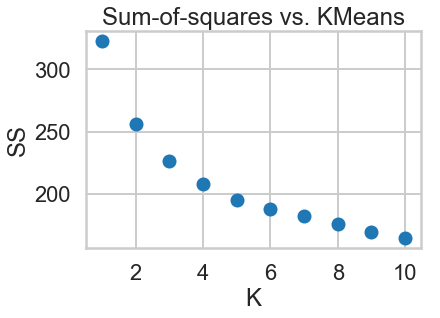

In [32]:
# Plot SS 
import numpy as np
k = np.array(range(1,11))
plt.scatter(k, SS)
plt.xlabel('K')
plt.ylabel('SS')
plt.title('Sum-of-squares vs. KMeans')

In the scatter plot above, we observe a significant drop in SS between group 1 and 2 (>100). It is the largest difference 
before tapering off to smaller decreases in SS. It is the "elbow point" of the plot before it starts descending slowly. 
Therefore we choose 2 as our optimal K value. 

A challenge that may present itself when using the elbow method is not having a distinct elbow point. If it is unclear in 
a plot, this may lead to incorrect results for picking the optimum K value. 

In [33]:
cluster = KMeans(n_clusters=2, init='k-means++', random_state=42)
matrix['cluster2'] = cluster_2.fit_predict(matrix[matrix.columns[2:]])

Text(0, 0.5, 'Number of Customers')

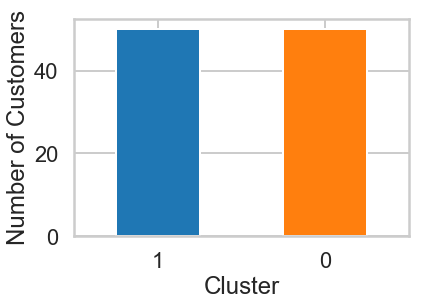

In [34]:
ax = matrix.cluster.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

The above bar plot shows two main clusters, customers who bought and customers who did not. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [35]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [36]:
# Calculate Silhouette 
sil_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i+1, init='k-means++', random_state=42)
    kmeans.fit(X)
    sil_score.append(silhouette_score(X, kmeans.predict(X)))

Text(0.5, 1.0, 'Silhouette Score vs. K')

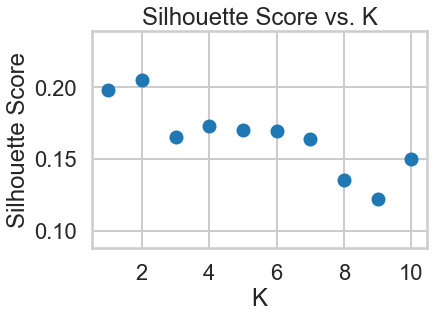

In [40]:
# Plot Silhouette 
k = np.array(range(1,11))
plt.scatter(k, sil_score)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. K')

In [48]:
# Testing clusters, test 3 or other values 
from sklearn.cluster import KMeans
cluster_3 = KMeans(n_clusters=3)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster3'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()

2    50
0    30
1    20
Name: cluster, dtype: int64

Text(0, 0.5, 'Number of Customers')

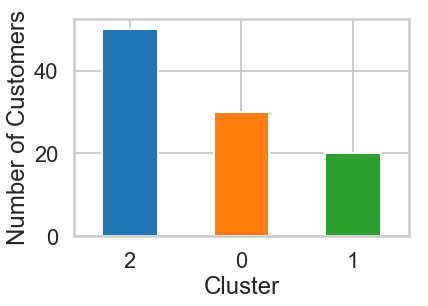

In [49]:
cluster_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
matrix['cluster3'] = cluster.fit_predict(matrix[matrix.columns[2:]])
ax = matrix.cluster.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

For n_clusters = 2 The average silhouette_score is : 0.1979488291802172
For n_clusters = 3 The average silhouette_score is : 0.20493017189023996
For n_clusters = 4 The average silhouette_score is : 0.1654353418908229
For n_clusters = 5 The average silhouette_score is : 0.1731508907861858
For n_clusters = 6 The average silhouette_score is : 0.16991049644773526


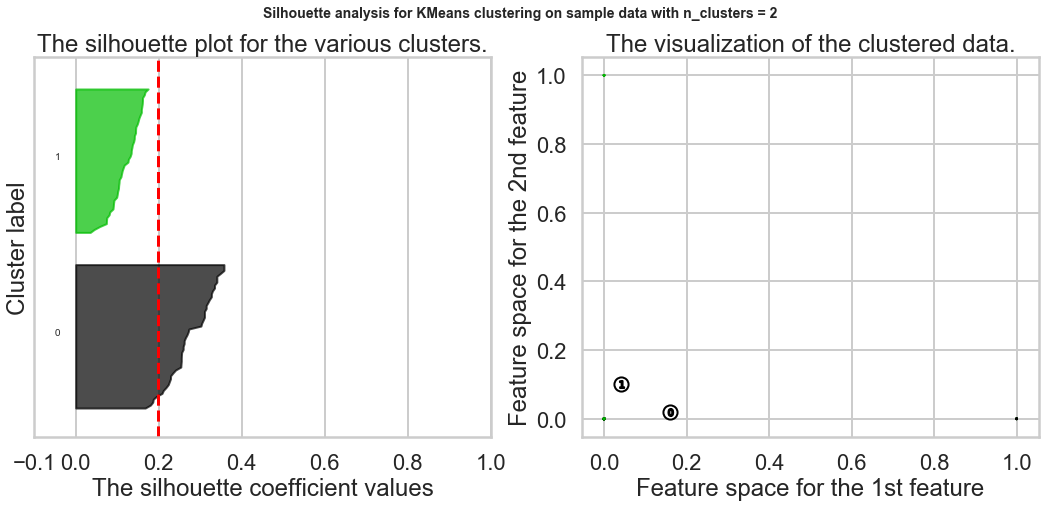

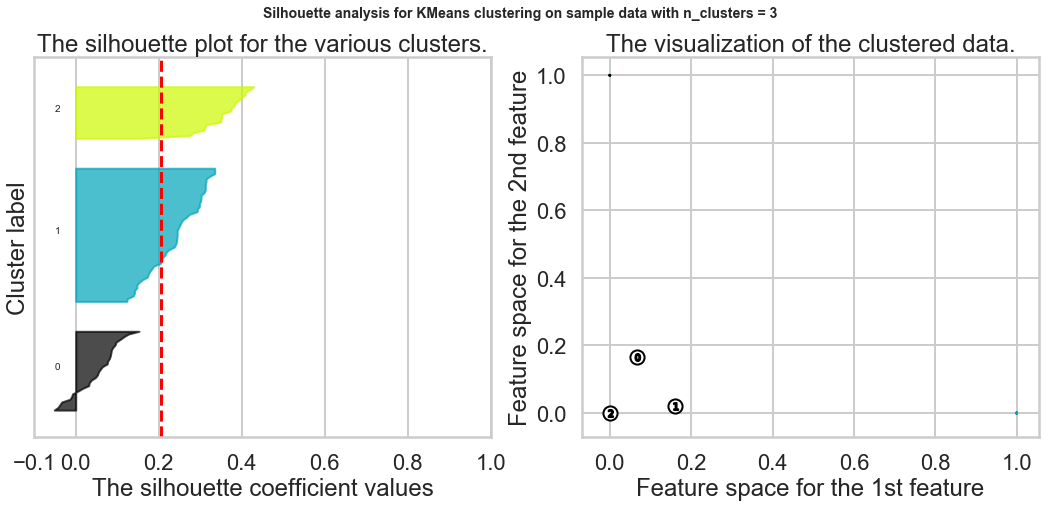

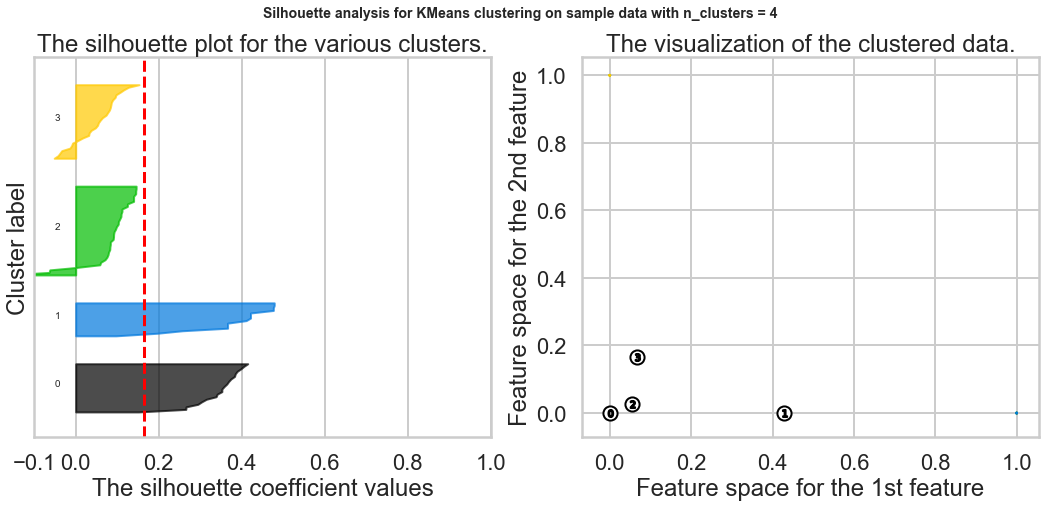

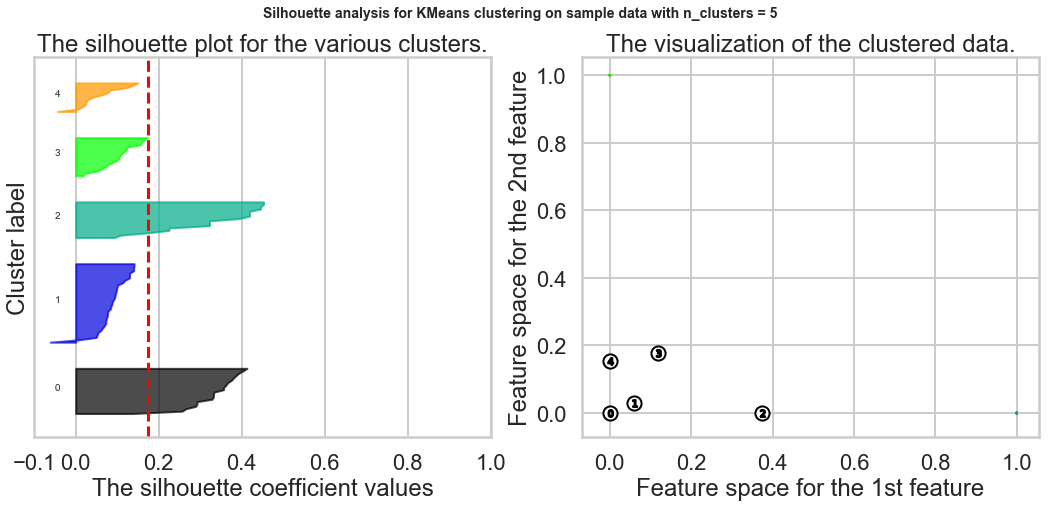

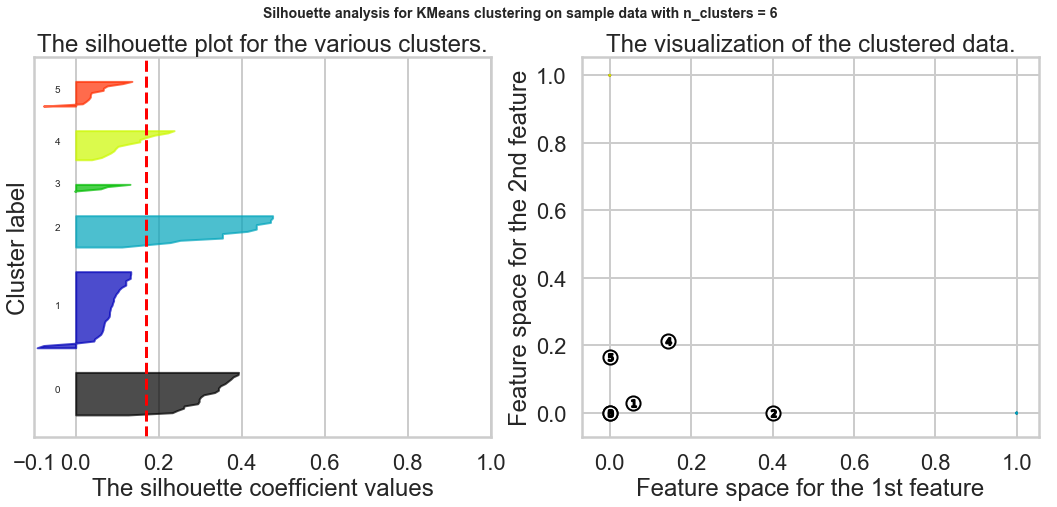

In [39]:
# The Silhouette Method -- https://www.scribd.com/document/354048592/mini-project-clustering 
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

After calculating the silhouette scores above, cluster 3 had the highest silhouette score at 0.20493017189023996 
Closely followed by 0.1979488291802172 for cluster 2. All of the scores are below average and do not show strong clustering. 
Silhouette scores ranging from -1 to 1, the higher the score the better. Below 25% is considered weak and possibly 
artificial. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(X)[:,0]
matrix['y'] = pca.fit_transform(X)[:,1]

In [50]:
# Create the dataframe 
customer_clusters = matrix[['customer_name', 'cluster2', 'cluster3', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster2,cluster3,x,y
0,Adams,1,1,-0.877637,0.892142
1,Allen,0,2,0.769197,-0.179173
2,Anderson,0,2,1.133160,-0.045808
3,Bailey,1,1,-0.760146,0.581338
4,Baker,0,2,0.546506,0.067681


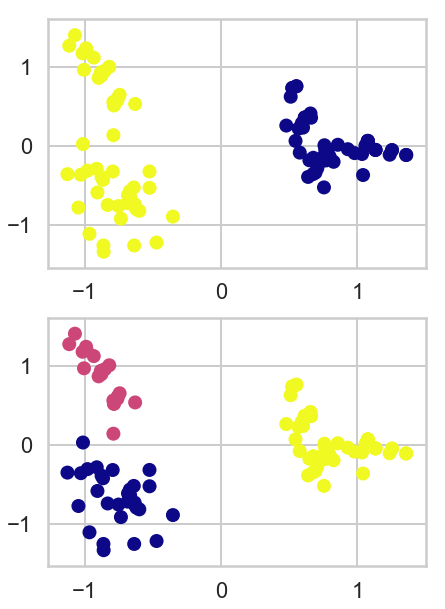

In [52]:
# Plot 2 clusters
plt.subplot(2,1,1)
plt.scatter('x', 'y', data=matrix, c='cluster2', cmap='plasma')

# Plot 3 clusters
plt.subplot(2,1,2)
plt.scatter('x', 'y', data=matrix, c='cluster3', cmap='plasma')

plt.subplots_adjust(left=0.125, bottom=0.1, right=1, top=2, wspace=None, hspace=0.2)



It appears that 2 clusters is an optimal K value. This produces 2 distinct clusters with considerable distance between
them. With 3 clusters, there is less distinction and the clusters are closer to each other. It appears that the Elbow 
method produces a more optimal K value over the Silhouette method. 

# Let's take a closer look at what the clusters mean:

In [54]:
matrix['is_0'] = matrix.cluster2==0

In [55]:
matrix_merge = matrix.merge(df_transactions, on='customer_name', how='outer')

In [56]:
matrix_merge_all= matrix_merge.merge(df_offers, on='offer_id', how='outer')[['customer_name', 'cluster2', 'varietal', 'min_qty', 'discount', 'origin']]

In [60]:
# Cluster 2, members 0
matrix_merge_all['is_0'] = matrix_merge_all.cluster2==0
matrix_merge_all.groupby('is_0').varietal.value_counts()

is_0   varietal          
False  Champagne             63
       Espumante             31
       Prosecco              28
       Malbec                27
       Cabernet Sauvignon    19
       Merlot                12
       Pinot Grigio          11
       Chardonnay             6
       Pinot Noir             5
True   Pinot Noir            39
       Champagne             18
       Prosecco              15
       Cabernet Sauvignon    13
       Chardonnay             9
       Espumante              9
       Merlot                 8
       Pinot Grigio           6
       Malbec                 5
Name: varietal, dtype: int64

In [61]:
# Cluster 2, members 1
matrix_merge_all['is_1'] = matrix_merge_all.cluster2==1
matrix_merge_all.groupby('is_1').varietal.value_counts()

is_1   varietal          
False  Pinot Noir            39
       Champagne             18
       Prosecco              15
       Cabernet Sauvignon    13
       Chardonnay             9
       Espumante              9
       Merlot                 8
       Pinot Grigio           6
       Malbec                 5
True   Champagne             63
       Espumante             31
       Prosecco              28
       Malbec                27
       Cabernet Sauvignon    19
       Merlot                12
       Pinot Grigio          11
       Chardonnay             6
       Pinot Noir             5
Name: varietal, dtype: int64

In cluster 2 above, we see that members 0 do not like Champagne or Espumante (63, 31) while members 1 favor it. 
We also see that members 0 like Pinot Noir and Champagne (39, 18) while members 1 do not favor it. 

In [67]:
# Sort by origin
matrix_merge_all['is_1'] = matrix_merge_all.cluster2==1
matrix_merge_all.groupby('is_1').origin.value_counts()

is_1   origin      
False  France          33
       Australia       22
       Italy           16
       Chile           11
       Germany         10
       California       9
       South Africa     9
       New Zealand      6
       Oregon           6
True   France          95
       Chile           26
       Oregon          20
       Australia       17
       South Africa    16
       Italy            8
       California       7
       New Zealand      7
       Germany          6
Name: origin, dtype: int64

The above analysis shows cluster 2 favors wine from France, Chile, and Oregon. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

C:\Users\jwhoj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jwhoj\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


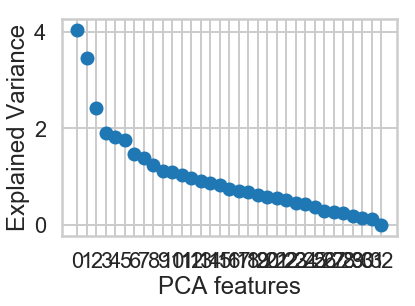

In [81]:
# PCA variances
# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'X'
pipeline.fit(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.scatter(features, pca.explained_variance_)
plt.xlabel('PCA features')
plt.ylabel('Explained Variance')
plt.xticks(features)
plt.show()


Analyzing the graph above, we see that between the 2nd and 3rd point is the largest drop before tapering/decreasing 
slowing. This is our elbow point, so we will choose 3 as our optimal dimension value. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [82]:
# 1. Affinity propagation 

from sklearn.cluster import AffinityPropagation

In [83]:
ap = AffinityPropagation()
matrix['clusters_ap'] = ap.fit_predict(X)

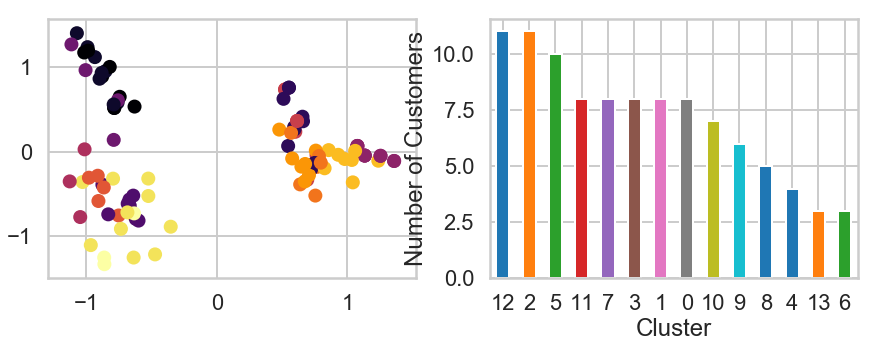

In [85]:
# Plot pca results of Affinity Propagation
plt.subplot(1,2,1)
plt.scatter('x', 'y', data=matrix, c='clusters_ap', cmap='inferno')

# plot cluster vs # of customers in each cluster
plt.subplot(1,2,2)
ax = matrix.clusters_ap.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=1, wspace=0.2, hspace=None)

There are 12 clusters for the Affinity Propagation model. This might be an excessive model. 

In [86]:
# 2. Spectral clustering
from sklearn.cluster import SpectralClustering

In [88]:
# Use 4 clusters for the spectral clustering
SC = SpectralClustering(n_clusters = 4)
SC.fit(X)
matrix['cluster_sc'] = SC.labels_

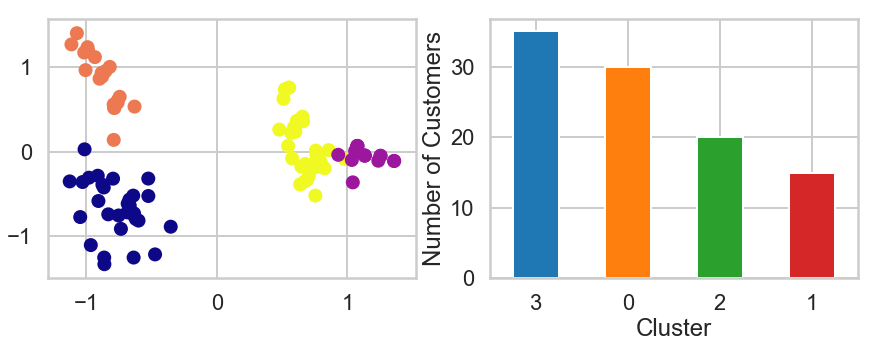

In [90]:
# Plot PCA results for Spectral Clustering
plt.subplot(1,2,1)
plt.scatter('x', 'y', data=matrix, c='cluster_sc', cmap='plasma')

# plot cluster vs # of customers in each cluster
plt.subplot(1,2,2)
ax = matrix.cluster_sc.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=1, wspace=0.2, hspace=None)

Spectral clustering has two sets of clusters that are a bit close too each other. 

In [91]:
# 3. Agglomerative clustering
# Use 4 clusters for the agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters = 4)
AC.fit(X)
matrix['cluster_ac'] = AC.labels_

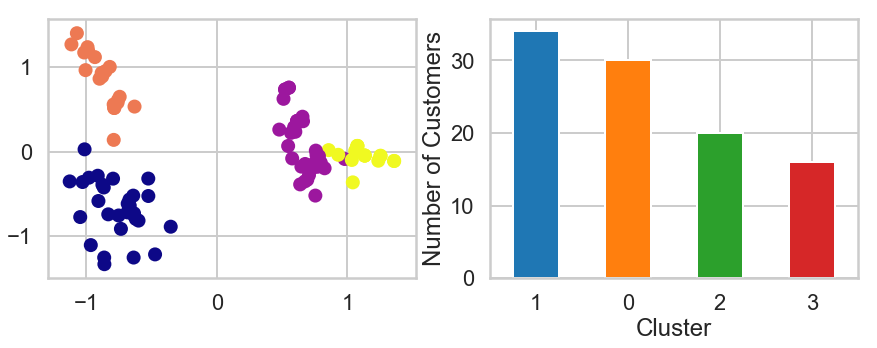

In [93]:
# Plot PCA results for agglomerative clustering
plt.subplot(1,2,1)
plt.scatter('x', 'y', data=matrix, c='cluster_ac', cmap='plasma')

# Plot cluster vs # of customers in each cluster
plt.subplot(1,2,2)
ax = matrix.cluster_ac.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=1, wspace=0.2, hspace=None)

Agglomerative clustering yields similar results to spectral clustering. Bar graphs descending uniformly, and 
cluster graphing is crowded for two sets of clusters. 

In [94]:
# 4. DBSCAN
from sklearn.cluster import DBSCAN
DB = DBSCAN()
matrix['cluster_db'] = DB.fit_predict(X)

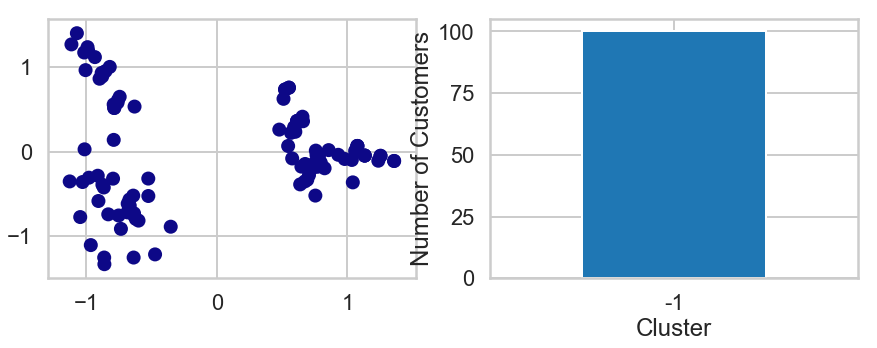

In [95]:
# Plot PCA results for agglomerative clustering
plt.subplot(1,2,1)
plt.scatter('x', 'y', data=matrix, c='cluster_db', cmap='plasma')

# Plot cluster vs # of customers in each cluster
plt.subplot(1,2,2)
ax = matrix.cluster_db.value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Customers')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=1, wspace=0.2, hspace=None)



For DBSCAN, it appears that there is only one cluster that is separated and spread out. It is also labeled -1 in the
bar graph. This does not seem like an efficient method. One possible explanation is that the model may think there is too
much noise that it cannot pick up on separated clusters. 

Agglomerative clustering and spectral are both good models as displayed above. They are similar in results to KMeans. 
Affinity has excessive clusters. DBSCAN was not efficient in picking up separate clusters. 